**MSA 2022 Phase 2 Data Science**

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

**Part 1 - Exploratory Data Analysis**

In [5]:
dataset = pd.read_csv("weather-data.csv")
dataset.head()

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00,21.0,12.0,56.38,16.0,NaN,NaN


In [6]:
dataset.tail()

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
103708,NZAA,2020-12-30 21:30,19.0,14.0,72.74,5.0,NaN,NaN
103709,NZAA,2020-12-30 22:00,19.0,14.0,72.74,6.0,NaN,NaN
103710,NZAA,2020-12-30 22:30,20.0,14.0,68.35,6.0,NaN,NaN
103711,NZAA,2020-12-30 23:00,20.0,14.0,68.35,7.0,NaN,NaN
103712,NZAA,2020-12-30 23:30,22.0,14.0,60.44,6.0,NaN,NaN


In [7]:
dataset.dtypes

 station           object
valid              object
tmpc              float64
dwpc              float64
relh              float64
sknt              float64
gust              float64
peak_wind_drct    float64
dtype: object

In [8]:
dataset.isnull().sum()

 station               0
valid                  0
tmpc                  35
dwpc                  35
relh                 120
sknt                   9
gust              102510
peak_wind_drct    103713
dtype: int64

In [9]:
print("Percent missing: gust ", dataset["gust"].isnull().sum() / len(dataset) *100)
print("Percent missing: peak_wind_drct ", dataset["peak_wind_drct"].isnull().sum() / len(dataset) *100)

Percent missing: gust  98.84006826530907
Percent missing: peak_wind_drct  100.0


We see that peak wind and gust are empty/ missing a large amount of data so we can remove those columns.


Dataset Mean

In [10]:
dataset[["tmpc","dwpc", "relh", "sknt"]].mean().head()

tmpc    15.811503
dwpc    12.115772
relh    79.782307
sknt     8.919029
dtype: float64

Dataset Standard Deviation

In [11]:
dataset[["tmpc","dwpc", "relh", "sknt"]].std().head()

tmpc     4.235197
dwpc     3.738005
relh    12.562199
sknt     5.348379
dtype: float64

Dataset 10th and 90th Percentile range

In [12]:
dataset[["tmpc","dwpc", "relh", "sknt"]].quantile([.1, .9]).head()

,tmpc,dwpc,relh,sknt
0.1,11.0,7.0,62.69,3.0
0.9,21.0,17.0,93.83,16.0


Dataset Correlation Plot

In [13]:
corr = dataset.corr()

corr.style.background_gradient(cmap='coolwarm')

C:\Users\jordan\anaconda3\lib\site-packages\pandas\io\formats\style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\jordan\anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
tmpc,1.000000,0.795403,-0.451405,0.235222,-0.168029,nan
dwpc,0.795403,1.000000,0.177898,-0.007093,-0.153984,nan
relh,-0.451405,0.177898,1.000000,-0.414763,-0.025576,nan
sknt,0.235222,-0.007093,-0.414763,1.000000,0.962926,nan
gust,-0.168029,-0.153984,-0.025576,0.962926,1.000000,nan
peak_wind_drct,nan,nan,nan,nan,nan,nan


We can see that this is a positive correlation between dew and temp, gust and windspeed and negative correlation between humidity in air and temperature and humidity and windspeed.

 Graphing any Numerical Sections of the dataset.

randomly sampled 100 for runtime with same random_state. Produces even amounts.

<AxesSubplot:>

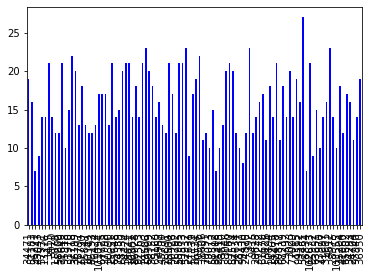

In [14]:
dataset_t_graph = dataset["tmpc"].sample(n=100, random_state = 1).plot(kind = "bar", color = 'blue')
dataset_t_graph

<AxesSubplot:>

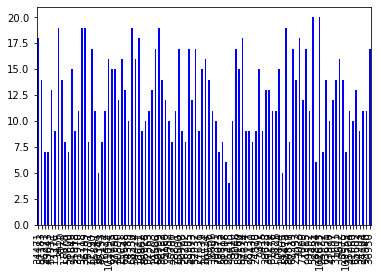

In [15]:
dataset_d_graph = dataset["dwpc"].sample(n=100, random_state = 1).plot(kind = "bar", color = 'blue')
dataset_d_graph

<AxesSubplot:>

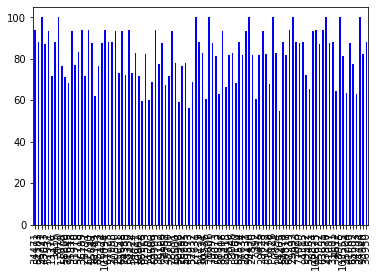

In [16]:
dataset_r_graph = dataset["relh"].sample(n=100, random_state = 1).plot(kind = "bar", color = 'blue')
dataset_r_graph

<AxesSubplot:>

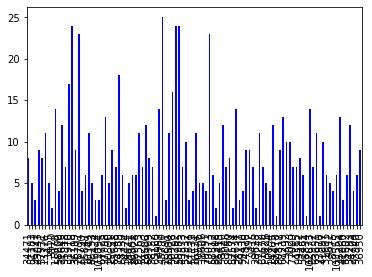

In [17]:
dataset_s_graph = dataset["sknt"].sample(n=100, random_state = 1).plot(kind = "bar", color = 'blue')
dataset_s_graph

**Part 2 - Data Preparation**

In [18]:
new_dataset = dataset[["valid","dwpc", "relh", "sknt", "tmpc"]]
new_dataset.head()

,valid,dwpc,relh,sknt,tmpc
0,2015-01-01 00:00,11.0,52.77,15.0,21.0
1,2015-01-01 00:30,10.0,49.37,16.0,21.0
2,2015-01-01 01:00,12.0,56.38,16.0,21.0
3,2015-01-01 01:30,13.0,60.21,16.0,21.0
4,2015-01-01 02:00,12.0,56.38,16.0,21.0


 Dataset converted to a form that a model can use.

In [19]:
new_dataset['valid'] = pd.to_datetime(new_dataset['valid'])

# Create new columns
new_dataset['day'] = new_dataset['valid'].dt.day
new_dataset['month'] = new_dataset['valid'].dt.month
new_dataset['year'] = new_dataset['valid'].dt.year
new_dataset['hour'] = new_dataset['valid'].dt.hour
new_dataset['minute'] = new_dataset['valid'].dt.minute
new_dataset = new_dataset.drop(columns=['valid'])
new_dataset.insert(0, 'tmpc', new_dataset.pop('tmpc'))

new_dataset.head()

C:\Users\jordan\AppData\Local\Temp\ipykernel_10432\2093037686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset['valid'] = pd.to_datetime(new_dataset['valid'])
C:\Users\jordan\AppData\Local\Temp\ipykernel_10432\2093037686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset['day'] = new_dataset['valid'].dt.day
C:\Users\jordan\AppData\Local\Temp\ipykernel_10432\2093037686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,tmpc,dwpc,relh,sknt,day,month,year,hour,minute
0,21.0,11.0,52.77,15.0,1,1,2015,0,0
1,21.0,10.0,49.37,16.0,1,1,2015,0,30
2,21.0,12.0,56.38,16.0,1,1,2015,1,0
3,21.0,13.0,60.21,16.0,1,1,2015,1,30
4,21.0,12.0,56.38,16.0,1,1,2015,2,0


Need to fill in NA values, going to impute with mean

In [20]:
new_dataset2 = new_dataset.fillna(new_dataset.mean())
new_dataset2.head()

,tmpc,dwpc,relh,sknt,day,month,year,hour,minute
0,21.0,11.0,52.77,15.0,1,1,2015,0,0
1,21.0,10.0,49.37,16.0,1,1,2015,0,30
2,21.0,12.0,56.38,16.0,1,1,2015,1,0
3,21.0,13.0,60.21,16.0,1,1,2015,1,30
4,21.0,12.0,56.38,16.0,1,1,2015,2,0


In [21]:
new_dataset2.dtypes

tmpc      float64
dwpc      float64
relh      float64
sknt      float64
day         int64
month       int64
year        int64
hour        int64
minute      int64
dtype: object

 Dataset train and test sets

choosing tmpc as our target variable because it correlates to the other values the most. ( or do i split 80 20 on total set because we dont need one target and the target is date?)


In [22]:
#sample to cut down total size of data for better runtime.
train_test_dataset = new_dataset2.sample(n = 10000, random_state = 1)

# get the locations
X = train_test_dataset.iloc[:, 1:]
y = train_test_dataset.iloc[:, 0]

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)

In [23]:
X.head()

,dwpc,relh,sknt,day,month,year,hour,minute
34471,18.0,93.92,8.0,10,1,2017,10,0
51183,14.0,87.92,5.0,30,12,2017,12,0
96271,7.0,100.00,3.0,28,7,2020,18,0
43043,7.0,87.28,9.0,13,7,2017,19,0
57931,13.0,93.69,8.0,20,5,2018,19,0


In [24]:
y.head()

34471    19.0
51183    16.0
96271     7.0
43043     9.0
57931    14.0
Name: tmpc, dtype: float64

In [25]:
print(X.shape)
print(y.shape)



(10000, 8)
(10000,)


In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 8)
(2000, 8)
(8000,)
(2000,)


**Ensure that you have also show some general information of the train/test dataset like in the EDA before entering the modelling stage.**

**Part 3 - Data Modelling**

In [27]:
GBR = GradientBoostingRegressor()


In [28]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [10,20,50,100, 200],
                  'max_depth'    : [4,6,8,10]
                 }

Training dataset fitted

In [29]:
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.04, max_depth=8, n_estimators=200,
                          subsample=0.2)

 The best score across ALL searched params:
 0.9991339480829843

 The best parameters across ALL searched params:
 {'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.2}


Testing dataset scored.
Checking performance of base models by evaluating the cross-validation RMSLE error.

In [30]:
GBR = grid_GBR.best_estimator_
GBR.fit(X_train, y_train)
GBR_pred = GBR.predict(X_test)
r2_GBR = r2_score(y_test, GBR_pred)
rmse_GBR = np.sqrt(mean_squared_error(y_test, GBR_pred))
print("R^2 Score: " + str(r2_GBR))
print("RMSE Score: " + str(rmse_GBR))

R^2 Score: 0.9997525701595552
RMSE Score: 0.06778935797465277


In [31]:
scores_GBR = cross_val_score(GBR, X_train, y_train, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_GBR)))

Cross Validation Score: 0.9995327540522222


Another month of the existing dataset predicted.
Final date from df is 2020-12-30 23:30 so predictions will range from 2021-01-01 to 2021-01-30 23:30


In [32]:
GBR.predict([[9.0,76.66,7.0,29,1,2021,9,30]])

C:\Users\jordan\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


array([13.00475174])

In [33]:
#final date from df is 2020-12-30 23:30 so predictions will range from 2021-01-01 to 2021-01-30 23:30
import random
np.random.seed(0)
# create an array of 5 dates starting at '2015-02-24', one per 30 minutes
rng = pd.date_range('2020-12-31', periods=1536, freq='30T')
prediction_df = pd.DataFrame({'valid': rng, 
                              'dwpc':  np.random.randint(low = dataset["dwpc"].min(), high = dataset["dwpc"].max(), size = len(rng)),
                              'relh':  np.random.randint(low = dataset["relh"].min(), high = dataset["relh"].max(), size = len(rng)),
                              'sknt':  np.random.randint(low = dataset["sknt"].min(), high = dataset["sknt"].max(), size = len(rng)),
                             })
prediction_df.head()

,valid,dwpc,relh,sknt
0,2020-12-31 00:00:00,10,34,3
1,2020-12-31 00:30:00,13,53,7
2,2020-12-31 01:00:00,19,31,27
3,2020-12-31 01:30:00,-2,57,2
4,2020-12-31 02:00:00,1,94,7


In [34]:
prediction_df['valid'] = pd.to_datetime(prediction_df['valid'])
# Create new columns
prediction_df['day'] = prediction_df['valid'].dt.day
prediction_df['month'] = prediction_df['valid'].dt.month
prediction_df['year'] = prediction_df['valid'].dt.year
prediction_df['hour'] = prediction_df['valid'].dt.hour
prediction_df['minute'] = prediction_df['valid'].dt.minute
prediction_df = prediction_df.drop(columns=['valid'])

prediction_df.head()

,dwpc,relh,sknt,day,month,year,hour,minute
0,10,34,3,31,12,2020,0,0
1,13,53,7,31,12,2020,0,30
2,19,31,27,31,12,2020,1,0
3,-2,57,2,31,12,2020,1,30
4,1,94,7,31,12,2020,2,0


In [35]:
GBR.predict(prediction_df)

array([26.23200918, 23.28184342, 29.54265595, ..., 21.01981615,
        2.52049122,  6.98614727])

In [46]:
prediction_outcomes_df = pd.DataFrame({'tmpc': GBR.predict(prediction_df), 'index' : rng})
prediction_outcomes_df

,tmpc,index
0,26.232009,2020-12-31 00:00:00
1,23.281843,2020-12-31 00:30:00
2,29.542656,2020-12-31 01:00:00
3,8.180650,2020-12-31 01:30:00
4,3.308308,2020-12-31 02:00:00
...,...,...
1531,1.790839,2021-01-31 21:30:00
1532,27.122588,2021-01-31 22:00:00
1533,21.019816,2021-01-31 22:30:00
1534,2.520491,2021-01-31 23:00:00


<AxesSubplot:>

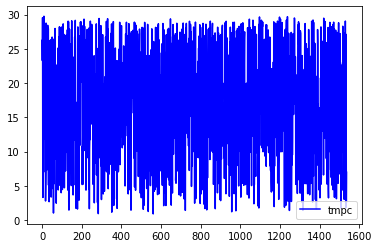

In [50]:
prediction_graph = prediction_outcomes_df.plot(y = "tmpc",  color = 'blue')
prediction_graph

We get predictions but they are completely random when predicting the future as we do not know the values for dwpc,relh and sknt.

**Conclusion**

*   My model is able to predict the test with a 99% accuracy. Take this with a grain of salt because i only used a sample of the entire dataset. I am also able to predict the future month.
*   My predictions are very interesting because i do not have values for dwpc,relh and sknt which makes my predictions very random and my scores very high for score testing earlier on
